Deep Learning
=============

The goal of this assignment is to train a Word2Vec CBOW model over [Text8](http://mattmahoney.net/dc/textdata) data.
<br>
Adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/5_word2vec.ipynb

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import pickle

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3084, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the CBOW model.

In [5]:
data_index = 0


def generate_batch(batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index

    span = 2 * skip_window + 1  # [ skip_window target skip_window ]

    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side

    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)

    # get words starting from index 0 to span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [skip_window]  # we only need to know the words around a given word, not the word itself

        # do this num_skips (2 times)
        # do this (1 time)

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j == span // 2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i, col_idx] = buffer[j]  # [skip_window] => middle element
            col_idx += 1
        labels[i, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0] == batch_size and batch.shape[1] == span - 1
    return batch, labels


Train a CBOW model.

In [6]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
# pick 16 samples from 100
valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
valid_examples = np.append(valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2))
num_sampled = 64  # Number of negative examples to sample.


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # embedding, vector for each word in the vocabulary
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embedding')
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    # this might efficiently find the embeddings for given ids (traind dataset)
    # manually doing this might not be efficient given there are 50000 entries in embeddings
    embeds = None
    for i in range(2 * skip_window):
        embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:, i])
        print('embedding %d shape: %s' % (i, embedding_i.get_shape().as_list()))
        emb_x, emb_y = embedding_i.get_shape().as_list()
        if embeds is None:
            embeds = tf.reshape(embedding_i, [emb_x, emb_y, 1])
        else:
            embeds = tf.concat([embeds, tf.reshape(embedding_i, [emb_x, emb_y, 1])], axis=-1)

    assert embeds.get_shape().as_list()[2] == 2 * skip_window
    print("Concat embedding size: %s" % embeds.get_shape().as_list())
    avg_embed = tf.reduce_mean(embeds, 2, keep_dims=False)
    print("Avg embedding size: %s" % avg_embed.get_shape().as_list())

    # Compute the softmax loss, using a sample of the negative labels each time.
    # inputs are embeddings of the train words
    # with this loss we optimize weights, biases, embeddings

    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights,
            biases=softmax_biases,
            labels=train_labels,
            inputs=avg_embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    # Adagrad is required because there are too many things to optimize
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
Concat embedding size: [128, 128, 2]
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Avg embedding size: [128, 128]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
num_steps = 200001

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

    # save normalized embedding
    normalized_embeddings = session.run(normalized_embeddings)
    np.save('embedding(CBOW)', normalized_embeddings)
    # save dictionary of data
    with open('dictionary(CBOW).pkl', 'wb') as file_stream:
        pickle.dump(dictionary, file_stream)

Initialized
Average loss at step 0: 7.677927
Nearest to eight: boson, telecommunications, maradns, mindstorms, clocked, relentless, payloads, pie,
Nearest to zero: passenger, kapitan, inquire, beach, mussolini, eightfold, arduous, equity,
Nearest to for: accessibility, umlauts, oswaldo, sic, fiedler, aap, service, involved,
Nearest to if: immanence, conclusions, ellen, praising, cornwallis, swayed, superstitious, acetylene,
Nearest to can: tributary, blend, extremadura, airtime, supremacist, sparkling, carbon, houghton,
Nearest to its: nurse, payload, spaulding, slobodan, retina, gibberish, xxxvii, picturesque,
Nearest to however: centaurs, catalysed, declaration, eeeeee, rodrigues, gerson, cotton, operas,
Nearest to on: shuttle, haarlem, understands, schwenkfeld, rationale, markkaa, dominant, al,
Nearest to brother: gojira, brigid, bian, internationally, peck, ral, lasers, departmental,
Nearest to taking: your, edinburgh, tikal, fulani, fencers, contrasts, enhancements, shusui,
Neares

Nearest to ice: shards, issues, recalcitrant, ayman, garry, basal, fountainhead, macdonald,
Average loss at step 52000: 2.886364
Average loss at step 54000: 2.859943
Average loss at step 56000: 2.856864
Average loss at step 58000: 2.764278
Average loss at step 60000: 2.827218
Nearest to eight: nine, seven, six, five, four, three, zero, two,
Nearest to zero: five, seven, six, four, eight, nine, three, thirds,
Nearest to for: without, additionally, despite, greenwich, obrenovi, when, rimet, including,
Nearest to if: when, though, where, before, know, perhaps, should, chico,
Nearest to can: may, could, must, will, would, should, might, cannot,
Nearest to its: their, his, the, pareto, her, our, your, overwhelm,
Nearest to however: but, although, though, since, that, until, while, chaining,
Nearest to on: upon, through, within, in, during, under, zug, around,
Nearest to brother: father, gojira, son, peck, avicenna, daughters, feb, kshatriya,
Nearest to taking: takes, binyamin, took, contras

Average loss at step 112000: 2.694200
Average loss at step 114000: 2.717557
Average loss at step 116000: 2.746095
Average loss at step 118000: 2.594893
Average loss at step 120000: 2.494087
Nearest to eight: six, nine, seven, four, five, three, zero, two,
Nearest to zero: five, seven, six, eight, nine, four, three, playstation,
Nearest to for: despite, sequenced, after, without, debug, crozier, recognizing, additionally,
Nearest to if: when, though, before, perhaps, where, else, pratt, sighting,
Nearest to can: could, must, will, should, might, may, would, cannot,
Nearest to its: their, his, her, the, our, pareto, your, whose,
Nearest to however: but, although, though, that, until, since, when, there,
Nearest to on: upon, through, within, in, during, zug, near, markkaa,
Nearest to brother: father, sister, son, gojira, daughters, peck, daughter, wife,
Nearest to taking: takes, took, leaving, dogme, bijapur, binyamin, take, winners,
Nearest to behind: mctell, distributive, sumatran, hand

Nearest to file: subsidiary, format, files, dreadnoughts, text, sseldorf, nonzero, document,
Nearest to ice: staging, museu, mathilde, shards, longbows, elevation, mirabilis, garry,
Average loss at step 172000: 2.607904
Average loss at step 174000: 2.599336
Average loss at step 176000: 2.576688
Average loss at step 178000: 2.537839
Average loss at step 180000: 2.523572
Nearest to eight: six, seven, nine, five, four, three, zero, two,
Nearest to zero: five, seven, eight, six, four, nine, three, two,
Nearest to for: including, additionally, despite, crozier, involves, wheeling, obrenovi, tighter,
Nearest to if: when, though, where, before, denotes, pratt, perhaps, so,
Nearest to can: could, must, may, might, should, cannot, will, would,
Nearest to its: their, his, her, our, pareto, whose, your, the,
Nearest to however: although, though, but, that, especially, while, whereas, except,
Nearest to on: upon, within, zug, through, in, legislate, mortally, aslan,
Nearest to brother: sister, son

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

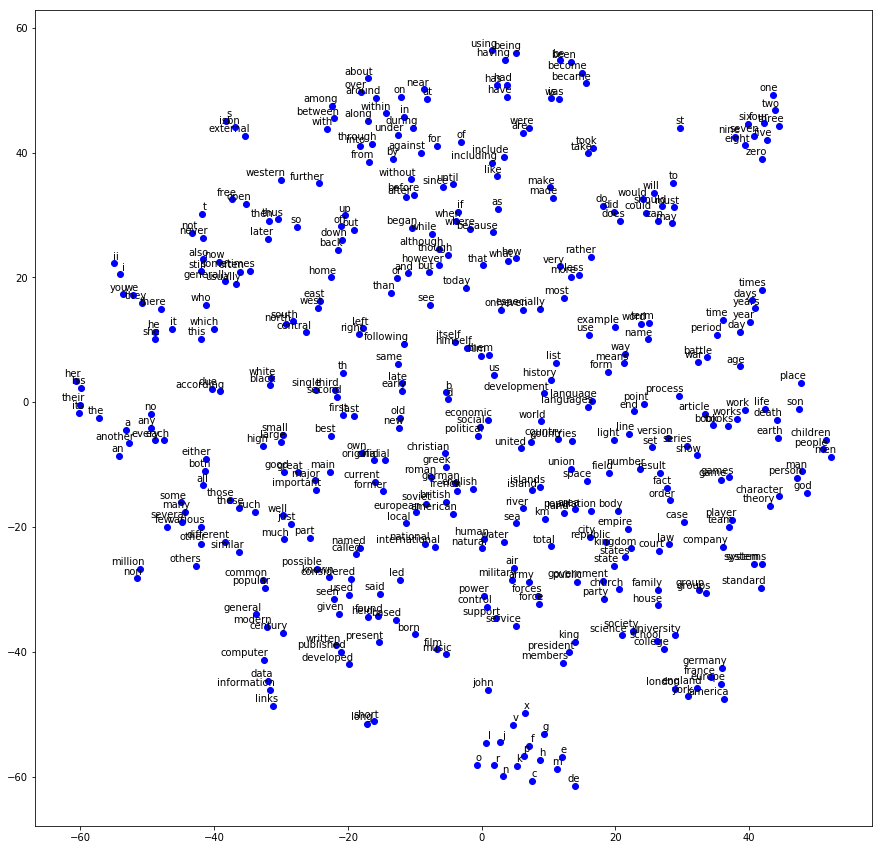

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y, color='b')
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)